<a href="https://colab.research.google.com/github/rasaviharhouse/Frame_Comparator/blob/main/FrameComparator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch as nn
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

In [ ]:

df = pd.read_csv('gt.txt', names = ['Frame', 'Id', 'Left', 'Top', 'Width', 'Height', 'Conf', 'x', 'y', 'z'])
print(df)

      Frame  Id  Left  Top  Width  Height  Conf  x  y  z
0         1   1  1367  393     73     225     1 -1 -1 -1
1         1   2  1477  417     73     175     1 -1 -1 -1
2         1   3   669  411     79     205     1 -1 -1 -1
3         1   4  1219  409     47     121     1 -1 -1 -1
4         1   5   469  431     71     175     1 -1 -1 -1
...     ...  ..   ...  ...    ...     ...   ... .. .. ..
6778    654   2  1237  331     55     141     1 -1 -1 -1
6779    654   4   859  315     63     181     1 -1 -1 -1
6780    654  15   931  333     61     161     1 -1 -1 -1
6781    654  16  1607  301    107     263     1 -1 -1 -1
6782    654  28  1161  339     35      73     1 -1 -1 -1

[6783 rows x 10 columns]


In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
frames_list = df['Frame'].unique()
frames_list[0]

1

In [ ]:
frames_list[len(frames_list)-1]

654

In [ ]:
# in inference step
from pandas.io.parsers.python_parser import DefaultDict
similarity = DefaultDict(list)
for i in range(1,frames_list[len(frames_list)-1]):
  df1=df[df['Frame'] == frames_list[i-1]]
  df2=df[df['Frame'] == frames_list[i]]

  for id1 in range(len(df1)):
    d1 = {
      'x1': df1['Left'].iloc[id1],
      'y1': df1['Top'].iloc[id1],
      'x2': df1['Left'].iloc[id1] + df1['Width'].iloc[id1],
      'y2': df1['Top'].iloc[id1] + df1['Height'].iloc[id1]
    }
    for id2 in range(len(df2)):
      d2 = {
          'x1': df2['Left'].iloc[id2],
          'y1': df2['Top'].iloc[id2],
          'x2': df2['Left'].iloc[id2] + df2['Width'].iloc[id2],
          'y2': df2['Top'].iloc[id2] + df2['Height'].iloc[id2]
      }
      iou = get_iou(d1, d2)
      # if(df1['Frame'].iloc[0]<2):
      #   print(df1['Frame'].iloc[0], ':', id1, '-', id2, ':', iou)
      if(iou>0.7):
        similarity[(df2['Frame'].iloc[0], id2)].append((id1, iou))
print(similarity)

defaultdict(<class 'list'>, {(2, 0): [(0, 0.9385465013806474)], (2, 1): [(1, 0.8024691358024691)], (2, 2): [(2, 0.8588235294117647)], (2, 3): [(3, 0.7735849056603774)], (2, 4): [(4, 0.8353528677388559)], (2, 5): [(5, 0.7808219178082192)], (2, 6): [(6, 0.8153846153846154)], (2, 7): [(7, 0.864406779661017)], (2, 9): [(9, 0.8032786885245902)], (3, 0): [(0, 0.9564790764790765)], (3, 1): [(1, 0.8303603409986389)], (3, 2): [(2, 0.8742252800363906)], (3, 3): [(3, 0.7735849056603774)], (3, 4): [(4, 0.8701298701298701)], (3, 5): [(5, 0.7808219178082192)], (3, 6): [(6, 0.8461538461538461)], (3, 7): [(7, 0.8526315789473684)], (3, 9): [(9, 0.8273302172119879)], (4, 0): [(0, 0.9656652360515021)], (4, 1): [(1, 0.8481012658227848)], (4, 2): [(2, 0.8893458786410502)], (4, 3): [(3, 0.7735849056603774)], (4, 4): [(4, 0.8701298701298701)], (4, 5): [(5, 0.8227539434580508)], (4, 6): [(6, 0.8371611276231649)], (4, 7): [(7, 0.8526315789473684)], (4, 9): [(9, 0.8597745394555952)], (5, 0): [(0, 0.983122362869

In [ ]:
# for plotting graph
from pandas.io.parsers.python_parser import DefaultDict

similarity = DefaultDict(list)
deduplication_precision = [0]*17
total_comparison = [0]*17
removed_objects = [0]*17
correct_prediction = [0]*17
thresholds = [i/100 for i in range(10, 95, 5)]

for i in range(1,frames_list[len(frames_list)-1]):
  df1=df[df['Frame'] == frames_list[i-1]]
  df2=df[df['Frame'] == frames_list[i]]
  removed_frame_object_ids = [set() for i in range(17)]
  for id1 in range(len(df1)):
    d1 = {
      'x1': df1['Left'].iloc[id1],
      'y1': df1['Top'].iloc[id1],
      'x2': df1['Left'].iloc[id1] + df1['Width'].iloc[id1],
      'y2': df1['Top'].iloc[id1] + df1['Height'].iloc[id1]
    }

    for id2 in range(len(df2)):
      d2 = {
          'x1': df2['Left'].iloc[id2],
          'y1': df2['Top'].iloc[id2],
          'x2': df2['Left'].iloc[id2] + df2['Width'].iloc[id2],
          'y2': df2['Top'].iloc[id2] + df2['Height'].iloc[id2]
      }
      iou = get_iou(d1, d2)
      similarity[(df2['Frame'].iloc[0], id2)].append((id1, iou))

      for idx, threshold in enumerate(thresholds):
        if(iou>threshold):
          if(df2['Id'].iloc[id2] == df1['Id'].iloc[id1]):
            correct_prediction[idx]+=1
            removed_frame_object_ids[idx].add(df2['Id'].iloc[id2])
          total_comparison[idx]+=1
          removed_frame_object_ids[idx].add(df2['Id'].iloc[id2])

  # if(i<3):
  #   print("Trace", removed_frame_object_ids)
  for i in range(17):
    removed_objects[i] += len(removed_frame_object_ids[i])

print(removed_objects)

deduplication_precision = [correct_prediction[i]*100/total_comparison[i] for i in range(17)]
removed_object_ratio = [removed_objects[i]*100/len(df) for i in range(17)]

print(similarity)
print(deduplication_precision)
print(removed_object_ratio)

[6765, 6761, 6760, 6758, 6757, 6757, 6757, 6752, 6724, 6710, 6677, 6580, 6449, 6161, 5700, 4939, 3672]
defaultdict(<class 'list'>, {(2, 0): [(0, 0.9385465013806474), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)], (2, 1): [(0, 0.0), (1, 0.8024691358024691), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)], (2, 2): [(0, 0.0), (1, 0.0), (2, 0.8588235294117647), (3, 0.0), (4, 0.0), (5, 0.12454461747868209), (6, 0.0), (7, 0.0802652641207409), (8, 0.0), (9, 0.0)], (2, 3): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.7735849056603774), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)], (2, 4): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.8353528677388559), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)], (2, 5): [(0, 0.0), (1, 0.0), (2, 0.2530668688941428), (3, 0.0), (4, 0.0), (5, 0.7808219178082192), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)], (2, 6): [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6,

In [ ]:
idx

16

In [ ]:
a = np.linspace(0.1, 0.9, 17)
a = list(range(10, 100, 5))
thresholds = [i/100 for i in range(10, 95, 5)]
thresholds

[0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9]

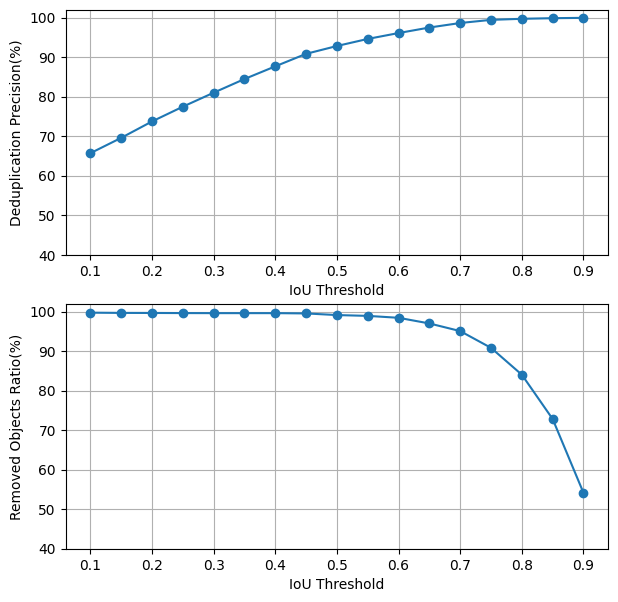

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7))
np_Y_1 = np.array(deduplication_precision)
np_X_1 = np.array(thresholds)
axs[0].set_ylim([40, 102])
axs[0].plot(np_X_1,np_Y_1, marker="o")
axs[0].grid(True)
axs[0].set_xlabel("IoU Threshold")
axs[0].set_ylabel("Deduplication Precision(%)")

np_Y_2 = np.array(removed_object_ratio)
np_X_2 = np.array(thresholds)
axs[1].set_ylim([40, 102])
axs[1].plot(np_X_2,np_Y_2, marker="o")
axs[1].grid(True)
axs[1].set_xlabel("IoU Threshold")
axs[1].set_ylabel("Removed Objects Ratio(%)")


plt.savefig("plt1.eps", format='eps')
plt.show()


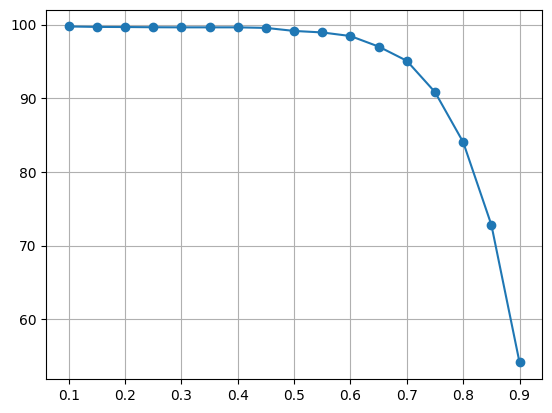

In [ ]:
np_Y = np.array(removed_object_ratio)
np_X = np.array(thresholds)
plt.plot(np_X,np_Y, marker="o")
plt.grid(True)
plt.show()